# About
* My second Kaggle notebook
* Feature engineering with tensorflow2 
* Binary classification Boosted Tree with tensorflow2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


# Dataset
* Titanic

## Get the data
* First import from csv

In [4]:
#import pandas as pd
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
raw_test = pd.read_csv("../input/titanic/test.csv")
raw_dataset = pd.read_csv("../input/titanic/train.csv")

dataset = raw_dataset.copy()
quizset = raw_test.copy()
provset = dataset.append(pd.concat([quizset,gender_submission['Survived']],axis=1,sort=False)).reset_index(drop=True)
datacount = len(dataset)
#dataset_y = dataset.pop('Survived')
#dataset_x = dataset

print('dataset:', len(dataset))  # DataFrame of training and validation
print('quizset:', len(quizset))  # DataFrame of quiz(Survived columns not exist)
print('provset: ',len(provset))  # DataFrame of provisioning (Survived columns NOT valid)

dataset: 891
quizset: 418
provset:  1309


In [5]:
provset.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Clean the data

In [6]:
# Many data is missing in Age but Name's title(Mr,Mrs,Master,etc..) will fill this gap a little.
provset['Title'] = provset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Titles seem to determine their fate
pd.crosstab(provset['Title'],provset['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [7]:
# Age mean,median per Title
age_mean = provset.groupby(['Title'])['Age'].mean()
age_median = provset.groupby(['Title'])['Age'].median()
age_std = provset.groupby(['Title'])['Age'].std()
pd.DataFrame([age_mean,age_median,age_std],index=['mean','median','std'])

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
mean,70.0,54.000000,33.0,40.0,39.0,43.571429,38.0,48.0,48.500000,5.482642,21.774238,24.0,24.0,32.252151,36.994118,28.0,41.250000,49.0
median,70.0,54.500000,33.0,40.0,39.0,49.000000,38.0,48.0,48.500000,4.000000,22.000000,24.0,24.0,29.000000,35.500000,28.0,41.500000,49.0
std,NaN,5.477226,NaN,NaN,NaN,11.731115,NaN,NaN,4.949747,4.161554,12.249077,0.0,NaN,12.422089,12.901767,NaN,12.020815,NaN


In [8]:
# Missing Data fill with median per Title
for title,subset in provset.groupby(['Title']):
    provset.loc[provset['Age'].isna() & (provset['Title'] == title), 'Age'] = age_median[title]
provset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,Mr
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Dona
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
1307,1308,0,3,"Ware, Mr. Frederick",male,29.0,0,0,359309,8.0500,NaN,S,Mr


In [9]:
# Cabin to Deck
provset['Deck'] = provset['Cabin'].str.extract('([A-Z])')

# Deck and Survived
pd.crosstab(provset['Deck'],provset['Pclass'])

Pclass,1,2,3
Deck,,,
A,22,0,0
B,65,0,0
C,94,0,0
D,40,6,0
E,34,4,3
F,0,13,8
G,0,0,5
T,1,0,0


In [10]:
# fill na class
provset.loc[provset['Embarked'].isna(), 'Embarked'] = 'O' # other class
#provset.loc[provset['Cabin'].isna(), 'Cabin'] = 'O' # other class
provset.loc[provset['Deck'].isna(), 'Deck'] = 'O' # other class

In [11]:
# add family_size
provset['FamilySize'] = provset['Parch'] + provset['SibSp'] + 1

# and add IsAlone
provset['IsAlone'] = 0
provset.loc[(provset['FamilySize'] == 1), 'IsAlone'] = 1
provset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,O,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,O,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,O,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,Mr,O,1,1
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Dona,C,1,1
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,O,1,1
1307,1308,0,3,"Ware, Mr. Frederick",male,29.0,0,0,359309,8.0500,NaN,S,Mr,O,1,1


In [12]:
# drop unreasonable columns
#provset = provset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
provset.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,IsAlone
1304,1305,0,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,Mr,O,1,1
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Dona,C,1,1
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,O,1,1
1307,1308,0,3,"Ware, Mr. Frederick",male,29.0,0,0,359309,8.0500,NaN,S,Mr,O,1,1
1308,1309,0,3,"Peter, Master. Michael J",male,4.0,1,1,2668,22.3583,NaN,C,Master,O,3,0


In [13]:
# one hot encoding
#provset = pd.get_dummies(provset, columns=['Sex','Embarked','Pclass','Title', 'Deck'])
#provset

# Split the data into dataset(x,yhat) and quizset(x)
* dataset is provset so that Survived flag in the last of 418 is dummy

In [14]:
dataset = provset[:datacount]
dataset_labels = dataset.pop('Survived')

# drop unreasonable columns
dataset_x = dataset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
dataset_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamilySize,IsAlone
0,3,male,22.0,1,0,7.2500,S,Mr,O,2,0
1,1,female,38.0,1,0,71.2833,C,Mrs,C,2,0
2,3,female,26.0,0,0,7.9250,S,Miss,O,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,C,2,0
4,3,male,35.0,0,0,8.0500,S,Mr,O,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Rev,O,1,1
887,1,female,19.0,0,0,30.0000,S,Miss,B,1,1
888,3,female,22.0,1,2,23.4500,S,Miss,O,4,0
889,1,male,26.0,0,0,30.0000,C,Mr,C,1,1


In [15]:
# quizset needs PassengerId
quizset = provset[datacount:].drop('Survived',axis=1)
quizset_x = quizset.drop(['Name', 'Ticket', 'Cabin'], axis=1)

## (Normalize the data)
* Do that in tf column

# Explore the data

In [16]:
provset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,O,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,O,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,O,1,1


In [17]:
provset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000
mean,655.000000,0.377387,2.294882,29.432521,0.498854,0.385027,33.295479,1.883881,0.603514
std,378.020061,0.484918,0.837836,13.163767,1.041658,0.865560,51.758668,1.583639,0.489354
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,328.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,655.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,982.000000,1.000000,3.000000,35.500000,1.000000,0.000000,31.275000,2.000000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,11.000000,1.000000


In [18]:
provset.shape, dataset_x.shape, dataset_labels.shape,quizset.shape

((1309, 16), (891, 11), (891,), (418, 15))

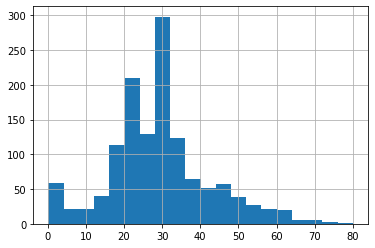

In [19]:
provset.Age.hist(bins=20)

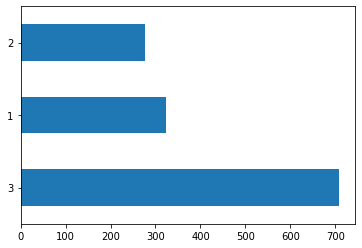

In [20]:
provset['Pclass'].value_counts().plot(kind='barh')

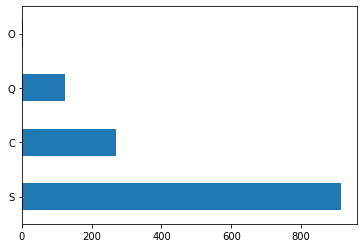

In [21]:
provset['Embarked'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

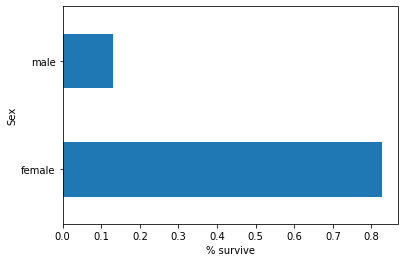

In [22]:
provset.groupby('Sex').Survived.mean().plot(kind='barh').set_xlabel('% survive')

# Create feature columns and input functions

In [23]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['Sex', 'Embarked', 'Pclass', 'Title', 'Deck', 'IsAlone' ]
NUMERIC_COLUMNS = ['Age', 'Fare', 'FamilySize']

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dataset_x[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))

In [24]:
example = dict(dataset_x.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Pclass', (1, 2, 3)))
print('Feature value: "{}"'.format(example['Pclass'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())
print('Feature value: "{}"'.format(example['IsAlone'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())
#dataset_x = dataset_x.head(1).fillna("O")

Feature value: "3"
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
One-hot encoded:  [[0. 0. 1.]]
Feature value: "0"
One-hot encoded:  [[0. 0. 1.]]


In [25]:
dataset_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamilySize,IsAlone
0,3,male,22.0,1,0,7.2500,S,Mr,O,2,0
1,1,female,38.0,1,0,71.2833,C,Mrs,C,2,0
2,3,female,26.0,0,0,7.9250,S,Miss,O,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,C,2,0
4,3,male,35.0,0,0,8.0500,S,Mr,O,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Rev,O,1,1
887,1,female,19.0,0,0,30.0000,S,Miss,B,1,1
888,3,female,22.0,1,2,23.4500,S,Miss,O,4,0
889,1,male,26.0,0,0,30.0000,C,Mr,C,1,1


In [26]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  2.  ,  7.25,  1.  ,  0.  ,
         1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ]], dtype=float32)

In [27]:
provset.shape, dataset.shape, quizset.shape # before data


((1309, 16), (891, 15), (418, 15))

In [28]:
dataset_x.shape, dataset_labels.shape # engineered data

((891, 11), (891,))

## (Split the data into train and test)
* Split data into train/test in Hold-out Validation
* But we don't split for Cross Validation

In [29]:
msk = np.random.rand(len(dataset_x)) < 0.8
train_x = dataset_x[msk]
eval_x = dataset_x[~msk]
train_labels = dataset_labels[msk]
eval_labels = dataset_labels[~msk]

In [30]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(train_labels)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(train_x, train_labels)
eval_input_fn = make_input_fn(eval_x, eval_labels, shuffle=False, n_epochs=1)

# Train and evaluate the model

## BoostedTreesClassifier

In [31]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
params = {
    'n_batches_per_layer': 1,
    'n_trees': 200, # 100
    'max_depth': 10, # 6
    'center_bias': True, # False
    'l2_regularization': 0.01
}
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
#est = tf.estimator.BoostedTreesClassifier(feature_columns,1)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\user\\AppData\\Local\\Temp\\tmphljwfjv2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\user\AppData\Local\Temp\tmphljwfjv2\model.ckpt.
Type is unsupported, or the types of the items don't match fie

In [33]:
# Eval.
result = est.evaluate(eval_input_fn)
print(pd.Series(result))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprected. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-04T11:15:31Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\user\AppData\Local\Temp\tmphljwfjv2\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.86250s
INFO:tensorflow:Finished evaluation at 2020-03-04-11:15:32
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.8363636, accuracy_baseline = 0.6363636, auc = 0.8836508, auc_precision_recall = 0.85169923, average_loss = 0.3931133, global_step = 100, label/mean = 0.36363637, loss = 0.3931133, precision = 0.779661, prediction/mean = 0.3784505, recall = 0.76666665
Type

In [34]:
# Make predictions.
sns_colors = sns.color_palette('colorblind')
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\user\\AppData\\Local\\Temp\\tmphljwfjv2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensor

In [35]:
# Create DFC Pandas dataframe.
labels = eval_labels.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
Fare,165.0,-0.010386,0.040888,-0.062166,-0.042992,-0.026519,0.032289,0.073750
Age,165.0,-0.009441,0.157074,-0.228578,-0.132227,-0.097173,0.126903,0.316550
Sex,165.0,-0.002025,0.014913,-0.016709,-0.011226,-0.010533,0.015852,0.030121
FamilySize,165.0,0.013423,0.018876,-0.035216,0.000605,0.006936,0.029866,0.068027
Embarked,165.0,-0.007652,0.012048,-0.030211,-0.019593,-0.006166,0.000673,0.025339
Title,165.0,-0.002552,0.043387,-0.060687,-0.037397,-0.029399,0.040097,0.088947
Deck,165.0,-0.008785,0.024202,-0.038984,-0.030593,-0.010825,0.006732,0.086398
Pclass,165.0,-0.007155,0.030815,-0.038410,-0.033087,-0.024765,0.009491,0.056543
IsAlone,165.0,-0.000243,0.001614,-0.009725,0.000000,0.000000,0.000000,0.000883


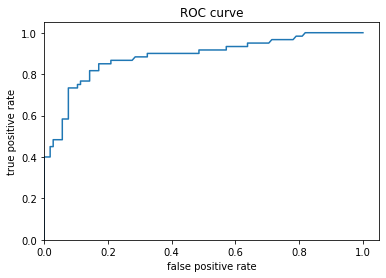

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(eval_labels, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [38]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\user\AppData\Local\Temp\tmphljwfjv2\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


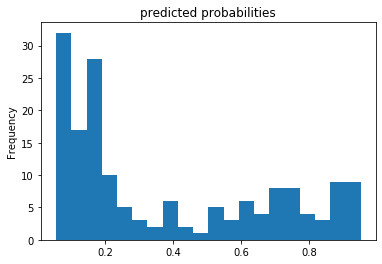

In [39]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

In [40]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(eval_x.iloc[ID][sorted_ix], ax)
  return ax

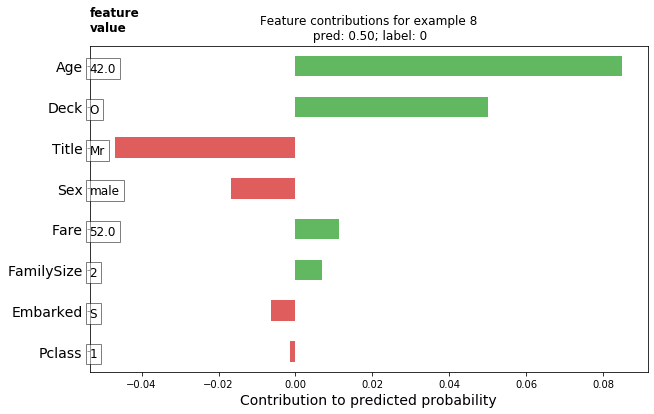

In [41]:
# Plot results.
ID = 8
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [42]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(eval_x.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

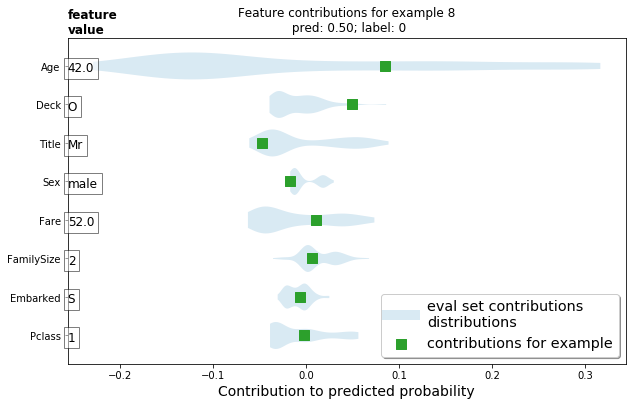

In [43]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

# Quiz prediction

In [44]:
# quiz_data
quizset_x_copy = quizset_x.copy()
pid = quizset_x_copy.pop('PassengerId')

def input_fn(features,batch_size=256):
    #quiz_input_fn = make_input_fn(quizset_x, None)
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)


# Generate predictions from the model
expected = [0, 1]

predictions = est.predict(input_fn=lambda: input_fn(quizset_x,1))

def get_pred_y():
    y = []
    for pred_dict in predictions:
        class_id = pred_dict['class_ids'][0]
        probability = pred_dict['probabilities'][class_id]
        y.append(expected[class_id])
    #return np.reshape(y,(-1,1))
    return y

submission = pd.DataFrame([np.array(pid),get_pred_y()],index=['PassengerId','Survived']).T
submission

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\user\AppData\Local\Temp\tmphljwfjv2\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [45]:
!rm ./submission.csv
submission.to_csv('submission.csv',index=False)

rm: ./submission.csv: No such file or directory
